# Milestone 02
# Peter Lorenz

## 0. Preliminaries

Import the required libraries:

In [53]:
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do not truncate numpy arrays
np.set_printoptions(threshold=sys.maxsize)

Declare constants:

Declare utility functions:

## 1. Split data from Milestone 1 into training and testing
In this section, we split the prepared data from Milestone 1 into training and test data sets. But first we must reload and clean this data.

### Read and clean data (from Milestone 1)
Here we follow the steps taken in Milestone 1 to prepare our data for modeling. Commentary is kept to a minimum as these matters have already been discussed in Milestone 1. Also, cell output is kept to the minimum necessary to confirm that the code is functioning as expected.

In [3]:
# Internet location of the data set and labels
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# Download sensor data and labels into a dataframe object, specify python engine for regex
sensor_data = pd.read_csv(url, sep='\s{1,}', engine='python')
sensor_labels_data = pd.read_csv(labels_url, sep='\s{1,}', engine='python')

# Generate index-based column names for the sensor data set
sensor_data.columns = list('s' + str(idx + 1) for idx in range(0, sensor_data.shape[1]))

# Assign column names to the labels
sensor_labels_data.columns = ['result', 'date', 'time']

# Save the original data frame for future reference as we modify its contents
sensor_data_orig = sensor_data

# Confirm that data set and labels are loaded
print('Sensor data set:')
sensor_data.shape
sensor_data.head()

print('Sensor labels:')
sensor_labels_data.shape
sensor_labels_data.head()

Sensor data set:


(1566, 590)

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
0,3095.780,2465.140,2230.422,1463.661,0.829,100.000,102.343,0.125,1.497,-0.001,...,0.006,208.204,0.502,0.022,0.005,4.445,0.010,0.020,0.006,208.204
1,2932.610,2559.940,2186.411,1698.017,1.510,100.000,95.488,0.124,1.444,0.004,...,0.015,82.860,0.496,0.016,0.004,3.175,0.058,0.048,0.015,82.860
2,2988.720,2479.900,2199.033,909.793,1.320,100.000,104.237,0.122,1.488,-0.012,...,0.004,73.843,0.499,0.010,0.003,2.054,0.020,0.015,0.004,73.843
3,3032.240,2502.870,2233.367,1326.520,1.533,100.000,100.397,0.123,1.503,-0.003,...,nan,nan,0.480,0.477,0.104,99.303,0.020,0.015,0.004,73.843
4,2946.250,2432.840,2233.367,1326.520,1.533,100.000,100.397,0.123,1.529,0.017,...,0.005,44.008,0.495,0.019,0.004,3.828,0.034,0.015,0.005,44.008


Sensor labels:


(1566, 3)

,result,date,time
0,-1,"""19/07/2008","12:32:00"""
1,1,"""19/07/2008","13:17:00"""
2,-1,"""19/07/2008","14:43:00"""
3,-1,"""19/07/2008","15:22:00"""
4,-1,"""19/07/2008","17:53:00"""


Drop columns with more than 5% NaN:

In [4]:
# Count NaN's per column
df_na = sensor_data.isna().sum()

# Identify columns above cutoff of 5% NaN's
nan_5_pct = df_na[df_na > 0.05 * sensor_data.shape[0]]

# Drop columns with more than 5% NaN's
sensor_data = sensor_data.drop(list(nan_5_pct.index), axis=1)
sensor_data.shape

(1566, 538)

Impute fields with NaN in the remaining columns:

In [5]:
# Impute and replace missing values using column median
sensor_data = sensor_data.replace('?', 
                                  np.NaN).apply(lambda x: x.fillna(x.median()))

Remove columns with zero variance:

In [6]:
# Identify columns with zero variance
zero_variance_cols = np.array(sensor_data.columns[sensor_data.var() == 0])

# Drop columns with zero variance
sensor_data = sensor_data.drop(zero_variance_cols, axis=1)

Remove columns consisting of more than 20% zeros:

In [7]:
# Count zeroes per column
zero_counts = sensor_data[sensor_data == 0].count(axis=0)

# Identify columns above cutoff of 20% zero
zero_20_pct = zero_counts[zero_counts > 0.2 * sensor_data.shape[0]]

# Drop columns with more than 20% zeros
sensor_data = sensor_data.drop(list(zero_20_pct.index), axis=1)
sensor_data.shape

(1566, 401)

Our data set is now almost ready for modeling. We deal with class imbalance and feature standardization after splitting the data into test and training sets.

### Split data into training and test
We now split the data into training and test sets, reserving 100 rows for testing and using the rest to train our models:

In [39]:
# Split data into training and test
X_train, X_test, y_train, y_test = \
    train_test_split(sensor_data, 
                     sensor_labels_data['result'], 
                     test_size = 0.0639, # 100 test rows
                     random_state = 0)

Now that the test data has been isolated, we can deal with class imbalance and feature standardization in the training data.

### Perform oversampling to balance classes
To address class imbalance we perform oversampling on the training data:

In [40]:
# Instantiate SMOTE reference
sm = SMOTE(random_state=1)

# Apply oversampling to model data and label column
X_resample, y_resample = sm.fit_resample(X_train, y_train)

# Convert resampled model data to dataframe
df_resample = pd.DataFrame(X_resample, columns=X_train.columns)

# Display shape and initial rows
df_resample.shape
df_resample.head()

# Convert labels array to dataframe
df_labels_resample = pd.DataFrame(y_resample, columns=['result'])

(2728, 401)

,s1,s2,s3,s4,s5,s7,s8,s9,s10,s11,...,s577,s578,s583,s584,s585,s586,s587,s588,s589,s590
0,3060.550,2420.030,2217.000,1436.831,1.660,93.661,0.120,1.616,-0.006,-0.011,...,1.358,12.201,0.499,0.015,0.003,2.919,0.016,0.041,0.012,259.283
1,3075.320,2491.070,2185.100,1201.049,0.782,105.849,0.121,1.400,-0.015,-0.001,...,1.097,16.904,0.497,0.013,0.003,2.577,0.022,0.011,0.003,47.069
2,3093.120,2500.900,2219.767,2086.471,1.338,98.890,0.123,1.412,0.009,-0.011,...,1.195,18.395,0.504,0.013,0.004,2.634,0.029,0.031,0.011,106.558
3,3012.410,2481.590,2141.067,1236.521,0.970,98.334,0.124,1.548,0.015,-0.003,...,1.922,16.213,0.496,0.014,0.004,2.775,0.015,0.010,0.003,64.882
4,3057.650,2540.350,2203.456,1441.145,0.826,104.677,0.123,1.553,-0.022,0.001,...,1.701,24.310,0.501,0.014,0.004,2.867,0.042,0.010,0.003,23.385


We confirm that the classes are balanced in the training set:

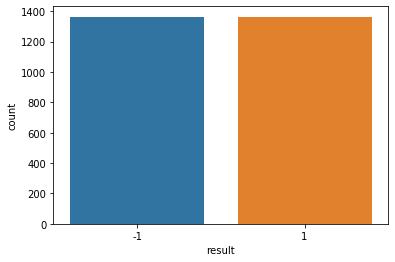

In [41]:
# Display plot of classes in the target variable
sns.countplot(x='result', data=df_labels_resample)

After oversampling, we now have equal numbers of positive and negative outcomes. We are ready to proceed to feature standardization.

### Feature standardization
We choose RobustScaler over StandardScaler due to the skewness of a significant number of features in the data set, as determined in Milestone 1. Because StandardScaler must compute the mean and standard deviation, it is susceptible to outliers. On the other hand, RobustScaler is based on percentiles and, hence, is less susceptible to outliers. We not apply RobustScaler to our training set:

In [42]:
# Scale data
scaler = RobustScaler()
X_resample = pd.DataFrame(scaler.fit_transform(df_resample), 
                          columns=df_resample.columns)

# Display scaled data set
X_resample.head()

,s1,s2,s3,s4,s5,s7,s8,s9,s10,s11,...,s577,s578,s583,s584,s585,s586,s587,s588,s589,s590
0,0.639,-1.015,0.525,0.307,0.849,-1.482,-0.963,1.805,-0.281,-1.117,...,-0.579,-0.287,-0.408,0.136,-0.336,0.133,-0.379,2.533,2.280,2.588
1,0.802,-0.081,-0.426,-0.216,-1.262,0.876,-0.597,-0.763,-0.806,-0.143,...,-1.140,0.637,-0.744,-0.216,-0.336,-0.202,0.129,-0.549,-0.528,-0.410
2,1.000,0.049,0.608,1.749,0.074,-0.470,0.459,-0.626,0.615,-1.117,...,-0.930,0.930,0.792,-0.118,0.350,-0.146,0.651,1.567,1.790,0.431
3,0.105,-0.205,-1.739,-0.137,-0.811,-0.578,0.622,0.991,0.961,-0.391,...,0.633,0.501,-1.033,-0.021,0.350,-0.008,-0.387,-0.590,-0.561,-0.158
4,0.606,0.568,0.122,0.317,-1.156,0.650,0.378,1.050,-1.194,0.039,...,0.159,2.093,0.120,0.097,-0.140,0.082,1.614,-0.621,-0.593,-0.744


We now turn to our results from Milestone 1 to select the features for our models.

### Feature selection
In Milestone 1, we applied four different methods to select the best features from our large set of features. Since stepwise selection produced the features with the most correlation with the other methods, we will go with the twenty best features chosen by this method:

1. s22
1. s34
1. s65
1. s104
1. s125
1. s130
1. s144
1. s189
1. s313
1. s438

Now that our training data set has been resampled and standardized, we are ready to proceed to modeling.

## 2. Build decision tree model
In this section, we build a decision tree model to detect faulty products. Using the gini coefficient, we begin by identifying the optimal value for the max_depth hyperparameter:

In [43]:
# Range of values to test (both methods)
param_grid = {'max_depth': np.arange(3, 7)}

# Metrics to prioritize
scoring = {'AUC': 'roc_auc'}

# Search trees under specified range of values
tree_dt = GridSearchCV(DecisionTreeClassifier(criterion = 'gini', 
                                              random_state=0), 
                       param_grid,
                       refit='AUC',
                       scoring=scoring)

# Fit model under optimal parameters
tree_dt.fit(X_resample, y_resample)
tree_pred_dt = tree_dt.predict(X_test)
tree_perf_dt = roc_auc_score(y_test, tree_pred_dt)

# Display optimal parameters
print('Optimal max depth: ', tree_dt.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([3, 4, 5, 6])},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_

Optimal max depth:  6


We now build our model using the optimal max_depth of 6 and display the confusion matrix, accuracy metrics, and ROC plot:

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Max depth: 6


array([[10, 88],
       [ 0,  3]], dtype=int64)

              precision    recall  f1-score   support

          -1       1.00      0.10      0.19        98
           1       0.03      1.00      0.06         3

    accuracy                           0.13       101
   macro avg       0.52      0.55      0.12       101
weighted avg       0.97      0.13      0.18       101



Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

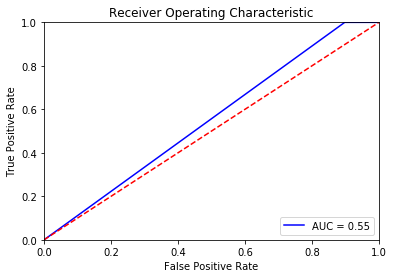

Area under the ROC curve (AUC): 0.5510204081632653


In [44]:
# Construct decision tree classifier
dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, 
                                random_state=0)
dt_clf.fit(X_resample, y_resample)

# Display tree depth
print('Max depth:', dt_clf.tree_.max_depth)

# Predict based on test data
y_pred_test_dt = dt_clf.predict(X_test)

# Display confusion matrix
confusion_matrix(y_test, y_pred_test_dt)

# Display performance metrics
print(classification_report(y_test, y_pred_test_dt))

# Compute ROC metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test_dt)
roc_auc = metrics.auc(fpr, tpr)

# Display ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Display ROC score
print('Area under the ROC curve (AUC):', 
     roc_auc_score(y_test, y_pred_test_dt))

The performance of the model is acceptable. All true positives were detected (3 of 3), though quite a few true negatives (over half) were incorrectly flagged as positives (25 out of 47).

## 3. Build ensemble model
In this section, we build an ensemble model to detect faulty products using a random forest to reduce the possibility of overfitting. We begin by finding the optimal values of the n_estimators and max_depth hyperparameters for our random forest:

In [49]:
# Features selected in Milestone 1
selected_features = ['s22', 's34', 's65', 's104', 's125', 's130', 's144', 's189', 's313', 's438']

# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(20, 100, 20),
               'max_depth': np.arange(4, 12, 4)}

# Search trees under specified range of values
gs = GridSearchCV(RandomForestClassifier(verbose=0, random_state=1), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_resample[selected_features], y_resample)
gs_pred = gs.predict(X_test[selected_features])
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                

Optimal number of estimators:  80
Optimal max depth:  8


Our search of hyperparameter values identified 80 as the optimal value for the n_estimators and 8 as the optimal max_depth. Now we build a random forest model using the subset of ten features chosen by forward selection (Milestone 1):

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

[0.085 0.139 0.086 0.176 0.109 0.1   0.098 0.094 0.062 0.051]


array([[10, 88],
       [ 0,  3]], dtype=int64)

              precision    recall  f1-score   support

          -1       1.00      0.10      0.19        98
           1       0.03      1.00      0.06         3

    accuracy                           0.13       101
   macro avg       0.52      0.55      0.12       101
weighted avg       0.97      0.13      0.18       101



Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

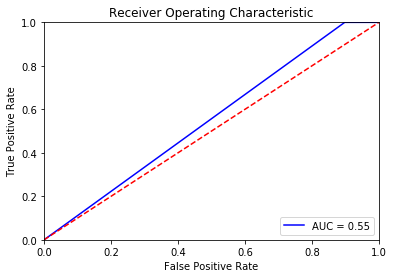

Area under the ROC curve (AUC): 0.5510204081632653


In [52]:
# Build random forest model
clf = RandomForestClassifier(n_estimators=80, max_depth=8, random_state=1, verbose=0)
clf.fit(X_resample[selected_features], y_resample)

# Generate predictions
pred_rf = clf.predict(X_test[selected_features])

# Display feature importance per feature
print(clf.feature_importances_)

# Display confusion matrix
confusion_matrix(y_test, pred_rf)

# Display performance metrics
print(classification_report(y_test, pred_rf))

# Display ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Display ROC score
print('Area under the ROC curve (AUC):', roc_auc_score(y_test, pred_rf))

The performance is not great with far too many false positives. So we turn to gradient boosting as a way to improve our model. We start by identifying optimal hyperparameters:

In [55]:
# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(10, 100, 10),
               'learning_rate': np.arange(0.05, 0.1, 0.05), 
               'max_depth': np.arange(4, 12, 2)}

# Search trees under specified range of values
gs = GridSearchCV(GradientBoostingClassifier(loss='deviance', verbose=0, random_state=0), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_resample[selected_features], y_resample)
gs_pred = gs.predict(X_test[selected_features])
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal learning rate (shrinkage): ', gs.best_params_['learning_rate'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...,
                

Optimal number of estimators:  90
Optimal learning rate (shrinkage):  0.05
Optimal max depth:  10


Our search of hyperparameter values identified 90 as the optimal value for n_estimators, 0.05 as the optimal shrinkage, and 10 as the optimal max_depth. Now we are ready to build our model using these parameters:

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[0.094 0.117 0.071 0.177 0.099 0.09  0.101 0.101 0.082 0.068]
              precision    recall  f1-score   support

          -1       0.98      0.87      0.92        98
           1       0.07      0.33      0.12         3

    accuracy                           0.85       101
   macro avg       0.52      0.60      0.52       101
weighted avg       0.95      0.85      0.90       101



Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

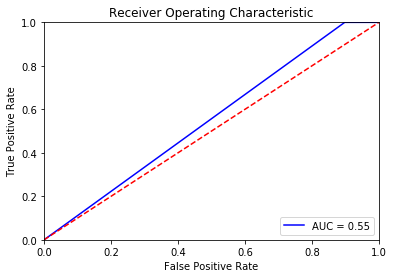

Area under the ROC curve (AUC): 0.6003401360544217


In [56]:
# Construct and fit model using gradient boosting
gbm_clf = GradientBoostingClassifier(n_estimators=90, loss='deviance', 
                                     learning_rate=0.05, max_depth=10)
gbm_clf.fit(X_resample[selected_features], y_resample)

# Display feature importances
print(gbm_clf.feature_importances_)

# Generate predictions
pred_gb = gbm_clf.predict(X_test[selected_features])

# Display confusion matrix
cm_gb = confusion_matrix(y_test, pred_gb)

# Display performance metrics
print(classification_report(y_test, pred_gb))

# Display ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Display ROC score
print('Area under the ROC curve (AUC):', roc_auc_score(y_test, pred_gb))

Even with gradient boosting we are not any closer to making quality predictions.

## 4. Build SVM model
In this section, we build an SVM model to detect faulty products.

## 5. Evaluate all three models
In this section, we evaluate the three models we have created above.

## 6. Conclusion
In this section, we describe our findings.